In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from modules.Utils.utils import DummyLogger
import sqlite3
from tqdm import tqdm
import time
import subprocess
import matplotlib.dates as mdates
from datetime import datetime
from astropy.table import Table
from tqdm.notebook import tqdm_notebook
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
%matplotlib inline

In [2]:
db_path = 'kpf_ts_oct2024_v2.db' # name of database file
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/kpf_ts_oct2024_v2.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 14928 obs x 1188 cols over 27 days in 20241001-20241027; updated 2025-02-06 18:56:34


In [10]:
myTS.print_metadata_table()

Derived Keywords:
------------------------------------------------------------------------------------------
Keyword                             Datatype  Units     Description                                                                               
------------------------------------------------------------------------------------------
D2_filename                         string    None      Full path to 2D file                                                                      
D2_header_read_time                 string    None      Last modification of 2D file                                                              
L0_filename                         string    None      Full path to L0 file                                                                      
L0_header_read_time                 string    None      Last modification of L0 file                                                              
L1_filename                         string    None      Full path

In [3]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute(
    """
    SELECT keyword, description
    FROM kpfdb_metadata
    WHERE source = "L2 RV Extension"
    ORDER BY keyword;
    """)
rows = cursor.fetchall()
keywords = [f'"{keyword}"' for keyword, description in rows if keyword]
query = f"""SELECT ObsID, OBJECT, [DATE-MID], NOTJUNK, GOODREAD, CCFBCV, CCFBJD
    {', '.join(keywords)} 
    FROM kpfdb
    WHERE NOTJUNK = 1.0"""
df = pd.read_sql_query(query, conn)
conn.close()
df

,ObsID,OBJECT,DATE-MID,NOTJUNK,GOODREAD,CCFBCV,BCRV00,BCRV01,BCRV02,BCRV03,...,RVY57,RVY58,RVY59,RVY60,RVY61,RVY62,RVY63,RVY64,RVY65,RVY66
0,KP.20241001.10301.86,autocal-etalon-all-eve,2024-10-01T02:52:11.874,1,None,0.0,2.460585e+06,0.0,0.0,0.0,...,-0.00130827472970206,-0.00760824229698606,-0.00199172234737003,-0.00288828775534678,0.00130673530612248,0.00239084636752753,-0.00277932967909856,0.00388399486215854,0.00107319289230412,0.00489830505736588
1,KP.20241001.07291.81,autocal-thar-all-eve,2024-10-01T02:01:41.824,1,None,0.0,2.460585e+06,0.0,0.0,0.0,...,0.0322312943816888,-0.00321590931519954,-0.0895597569039569,0.321737545134191,1.38918655027924,-0.057344388665689,0.650780786566121,-0.00817161218970369,-0.181667498640184,0.642375722015281
2,KP.20241001.00018.07,autocal-flat-all,2024-10-01T00:00:23.084,1,None,0.0,2.460585e+06,0.0,0.0,0.0,...,0.0,83.9322541938712,-104.176819224284,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KP.20241001.01597.80,autocal-flat-all,2024-10-01T00:26:42.804,1,None,0.0,2.460585e+06,0.0,0.0,0.0,...,0.0,82.9180924451676,-115.697387417828,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KP.20241001.03937.48,autocal-bias,2024-10-01T01:05:37.490,1,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14730,KP.20241027.71891.69,WideFlat_f4,2024-10-27T19:58:11.749,1,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,None,None
14731,KP.20241027.71942.46,WideFlat_f4,2024-10-27T19:59:02.523,1,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,None,None
14732,KP.20241027.71992.22,WideFlat_f5,2024-10-27T19:59:52.274,1,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,None,None
14733,KP.20241027.72042.88,WideFlat_f5,2024-10-27T20:00:42.933,1,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [4]:
df[df['BCRV00'].notnull()].head()

,ObsID,OBJECT,DATE-MID,NOTJUNK,GOODREAD,CCFBCV,BCRV00,BCRV01,BCRV02,BCRV03,...,RVY57,RVY58,RVY59,RVY60,RVY61,RVY62,RVY63,RVY64,RVY65,RVY66
0,KP.20241001.10301.86,autocal-etalon-all-eve,2024-10-01T02:52:11.874,1,None,0.0,2.460585e+06,0.0,0.0,0.0,...,-0.00130827472970206,-0.00760824229698606,-0.00199172234737003,-0.00288828775534678,0.00130673530612248,0.00239084636752753,-0.00277932967909856,0.00388399486215854,0.00107319289230412,0.00489830505736588
1,KP.20241001.07291.81,autocal-thar-all-eve,2024-10-01T02:01:41.824,1,None,0.0,2.460585e+06,0.0,0.0,0.0,...,0.0322312943816888,-0.00321590931519954,-0.0895597569039569,0.321737545134191,1.38918655027924,-0.057344388665689,0.650780786566121,-0.00817161218970369,-0.181667498640184,0.642375722015281
2,KP.20241001.00018.07,autocal-flat-all,2024-10-01T00:00:23.084,1,None,0.0,2.460585e+06,0.0,0.0,0.0,...,0.0,83.9322541938712,-104.176819224284,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KP.20241001.01597.80,autocal-flat-all,2024-10-01T00:26:42.804,1,None,0.0,2.460585e+06,0.0,0.0,0.0,...,0.0,82.9180924451676,-115.697387417828,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,KP.20241001.00076.69,autocal-flat-all,2024-10-01T00:01:21.698,1,None,0.0,2.460585e+06,0.0,0.0,0.0,...,0.0,98.8945733331142,-96.1114656310552,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
BCRV0 = df[df['BCRV00'].notnull()].copy()
BCRV1 = df[df['BCRV01'].notnull()].copy()
BCRV2 = df[df['BCRV02'].notnull()].copy()
BCRV3 = df[df['BCRV03'].notnull()].copy()
BCRV0.loc[:, 'BCRV00'] = BCRV0['BCRV00'].astype(float) * 1000
BCRV1.loc[:, 'BCRV01'] = BCRV1['BCRV01'].astype(float) * 1000
BCRV2.loc[:, 'BCRV02'] = BCRV2['BCRV02'].astype(float) * 1000
BCRV3.loc[:, 'BCRV03'] = BCRV3['BCRV03'].astype(float) * 1000

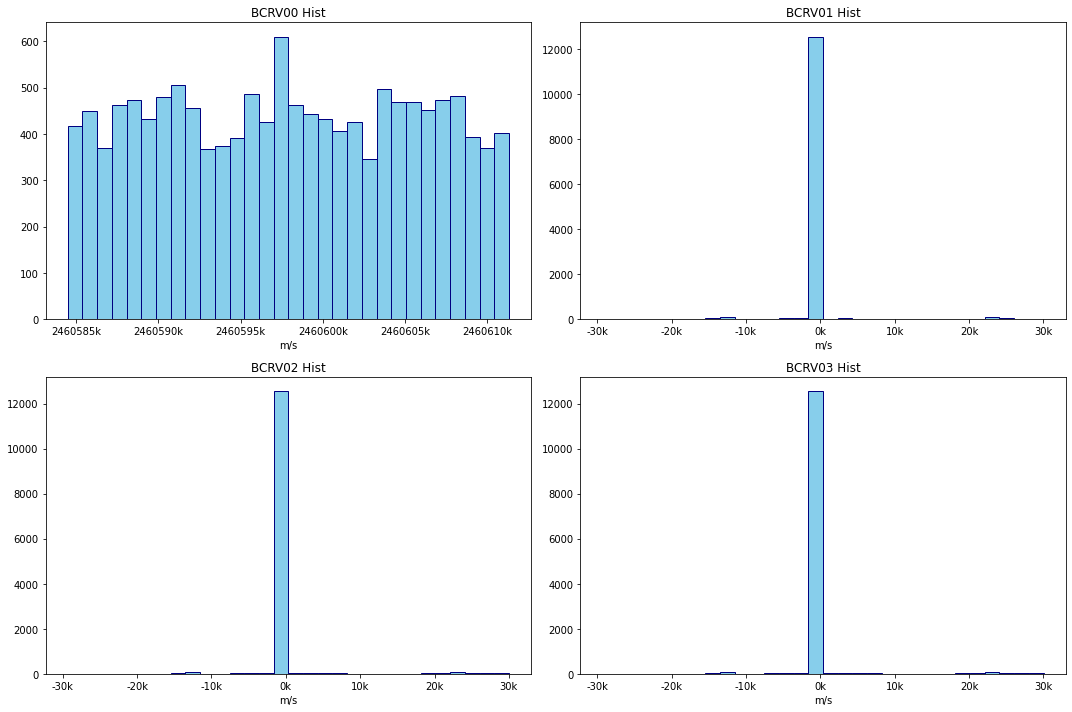

In [7]:
import matplotlib.ticker as ticker
def format_thousands(value, tick_number):
    return f'{int(value / 1000)}k'

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].hist(BCRV0['BCRV00'], bins=30, color='skyblue', edgecolor='navy')
axes[0][0].set_title('BCRV00 Hist')
axes[0][0].set_xlabel('m/s')
axes[0][0].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

axes[0][1].hist(BCRV1['BCRV01'], bins=30, color='skyblue', edgecolor='navy')
axes[0][1].set_title('BCRV01 Hist')
axes[0][1].set_xlabel('m/s')
axes[0][1].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

axes[1][0].hist(BCRV2['BCRV02'], bins=30, color='skyblue', edgecolor='navy')
axes[1][0].set_title('BCRV02 Hist')
axes[1][0].set_xlabel('m/s')
axes[1][0].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

axes[1][1].hist(BCRV3['BCRV03'], bins=30, color='skyblue', edgecolor='navy')
axes[1][1].set_title('BCRV03 Hist')
axes[1][1].set_xlabel('m/s')
axes[1][1].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

plt.tight_layout()
plt.show()

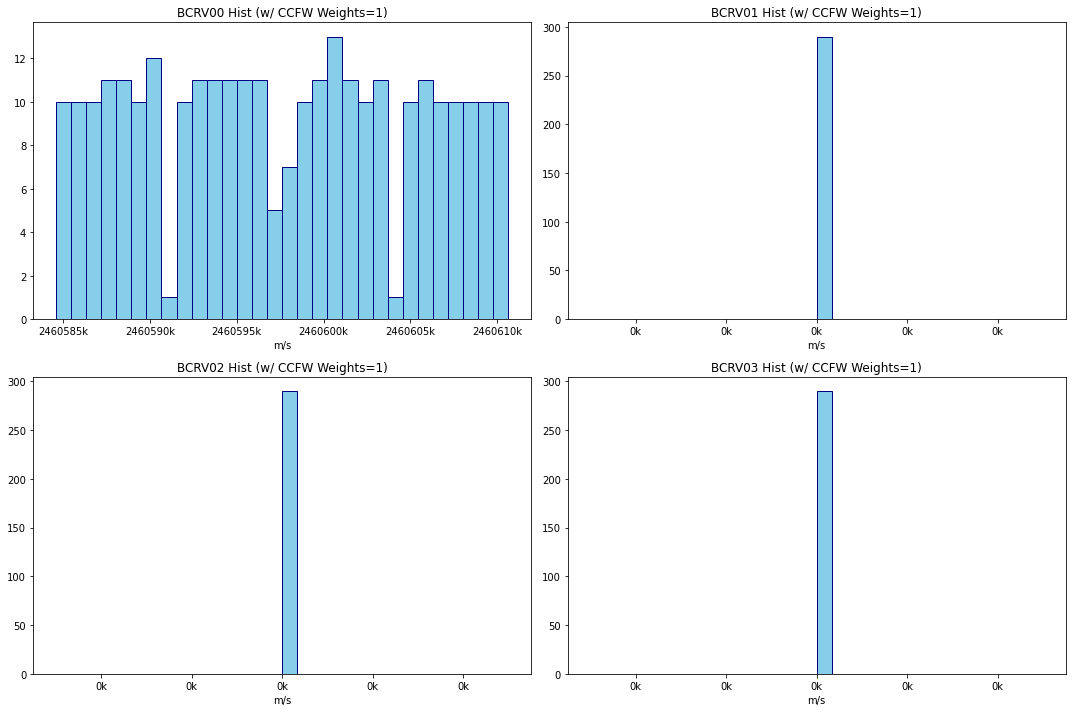

In [8]:
BCRV0_w = df[(df['BCRV00'].notnull()) & (df['CCFW00'].astype(float) == 1.0)].copy()
BCRV1_w = df[(df['BCRV01'].notnull()) & (df['CCFW01'].astype(float) == 1.0)].copy()
BCRV2_w = df[(df['BCRV02'].notnull()) & (df['CCFW02'].astype(float) == 1.0)].copy()
BCRV3_w = df[(df['BCRV03'].notnull()) & (df['CCFW03'].astype(float) == 1.0)].copy()
BCRV0_w.loc[:, 'BCRV00'] = BCRV0_w['BCRV00'].astype(float) * 1000
BCRV1_w.loc[:, 'BCRV01'] = BCRV1_w['BCRV01'].astype(float) * 1000
BCRV2_w.loc[:, 'BCRV02'] = BCRV2_w['BCRV02'].astype(float) * 1000
BCRV3_w.loc[:, 'BCRV03'] = BCRV3_w['BCRV03'].astype(float) * 1000

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].hist(BCRV0_w['BCRV00'], bins=30, color='skyblue', edgecolor='navy')
axes[0][0].set_title('BCRV00 Hist (w/ CCFW Weights=1)')
axes[0][0].set_xlabel('m/s')
axes[0][0].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

axes[0][1].hist(BCRV1_w['BCRV01'], bins=30, color='skyblue', edgecolor='navy')
axes[0][1].set_title('BCRV01 Hist (w/ CCFW Weights=1)')
axes[0][1].set_xlabel('m/s')
axes[0][1].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

axes[1][0].hist(BCRV2_w['BCRV02'], bins=30, color='skyblue', edgecolor='navy')
axes[1][0].set_title('BCRV02 Hist (w/ CCFW Weights=1)')
axes[1][0].set_xlabel('m/s')
axes[1][0].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

axes[1][1].hist(BCRV3_w['BCRV03'], bins=30, color='skyblue', edgecolor='navy')
axes[1][1].set_title('BCRV03 Hist (w/ CCFW Weights=1)')
axes[1][1].set_xlabel('m/s')
axes[1][1].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

plt.tight_layout()
plt.show()

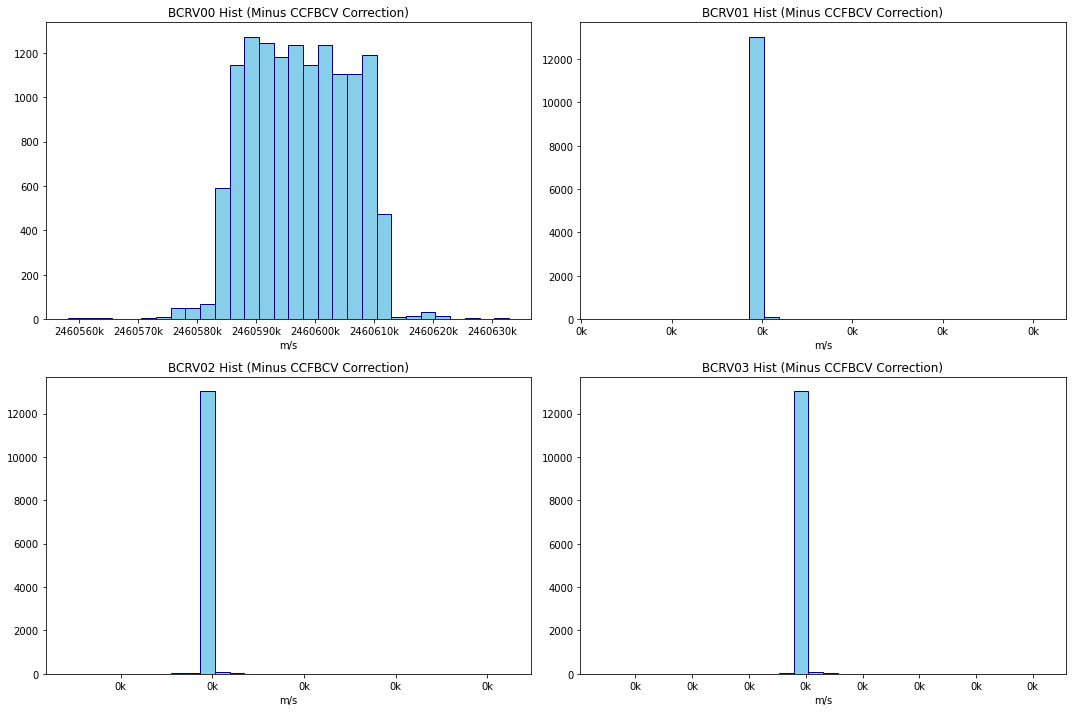

In [10]:
BCRV0.loc[:, 'BCRV0_Corr'] = BCRV0['BCRV00'] - (BCRV0['CCFBCV'].astype(float)*1000)
BCRV1.loc[:, 'BCRV1_Corr'] = BCRV1['BCRV01'] - (BCRV1['CCFBCV'].astype(float)*1000)
BCRV2.loc[:, 'BCRV2_Corr'] = BCRV2['BCRV02'] - (BCRV2['CCFBCV'].astype(float)*1000)
BCRV3.loc[:, 'BCRV3_Corr'] = BCRV3['BCRV03'] - (BCRV3['CCFBCV'].astype(float)*1000)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].hist(BCRV0['BCRV0_Corr'], bins=30, color='skyblue', edgecolor='navy')
axes[0][0].set_title('BCRV00 Hist (Minus CCFBCV Correction)')
axes[0][0].set_xlabel('m/s')
axes[0][0].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

axes[0][1].hist(BCRV1['BCRV1_Corr'], bins=30, color='skyblue', edgecolor='navy')
axes[0][1].set_title('BCRV01 Hist (Minus CCFBCV Correction)')
axes[0][1].set_xlabel('m/s')
axes[0][1].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

axes[1][0].hist(BCRV2['BCRV2_Corr'], bins=30, color='skyblue', edgecolor='navy')
axes[1][0].set_title('BCRV02 Hist (Minus CCFBCV Correction)')
axes[1][0].set_xlabel('m/s')
axes[1][0].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

axes[1][1].hist(BCRV3['BCRV3_Corr'], bins=30, color='skyblue', edgecolor='navy')
axes[1][1].set_title('BCRV03 Hist (Minus CCFBCV Correction)')
axes[1][1].set_xlabel('m/s')
axes[1][1].xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

plt.tight_layout()
plt.show()